In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
from pyspark.mllib.recommendation import ALS
from pyspark.sql.functions import col
import math
import random
import itertools
import copy
from joblib import Parallel, delayed
import multiprocessing
import pickle
import scipy.optimize as sco

from cross_validation import KFoldIndexes,CrossValidation
from cross_validation_blending import CrossValidationBlending
from models.als import *
from models.means import *
from models.medians import *
from models.helpers import *
from models.collaborative_filtering import *
from models.MF_SGD import *
from models.pyfm import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

pd.options.display.max_columns = 100
sc.setCheckpointDir('./checkpoint/')

/home/gael/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = load_csv()
train.head()

,User,Movie,Rating
0,44,1,4
1,61,1,3
2,67,1,4
3,72,1,3
4,86,1,5


In [3]:
models = {
    'global_mean': {
        'compute_predictions': True,
        'function': global_mean,
        'params': {}    
    },
    'global_median': {
        'compute_predictions': True,
        'function': global_median,
        'params': {}    
    },     
    'user_mean': {
        'compute_predictions': True,
        'function': user_mean,
        'params': {}
    },
    'user_median': {
        'compute_predictions': True,
        'function': user_median,
        'params': {}
    },    
    'movie_mean': {
        'compute_predictions': True,
        'function': movie_mean,
        'params': {}
    }, 
    'movie_mean_rescaled': {
        'compute_predictions': True,
        'function': movie_mean_rescaling,
        'params': {}
    },  
    'movie_median': {
        'compute_predictions': True,
        'function': movie_median,
        'params': {}
    },    
    'movie_median_rescaled': {
        'compute_predictions': True,
        'function': movie_median_rescaling,
        'params': {}
    },
    'movie_mean_deviation_user': {
        'compute_predictions': True,
        'function': movie_mean_deviation_user,
        'params': {}
    },
    'movie_mean_deviation_user_rescaled': {
        'compute_predictions': True,
        'function': movie_mean_deviation_user_rescaling,
        'params': {}
    },    
    'movie_median_deviation_user': {
        'compute_predictions': True,
        'function': movie_median_deviation_user,
        'params': {}
    },
    'movie_median_deviation_user_rescaled': {
        'compute_predictions': True,
        'function': movie_median_deviation_user_rescaling,
        'params': {}
    },    
    'als': {
        'compute_predictions': True,
        'function': predictions_ALS,
        'params': {
            'spark_context': sc,
            'rank': 8,
            'lambda_': 0.081, 
            'iterations': 24, 
            'nonnegative': True
        }
    },
    'als_rescaled': {
        'compute_predictions': True,
        'function': predictions_ALS_rescaling,
        'params': {
            'spark_context': sc,
            'rank': 8,
            'lambda_': 0.081, 
            'iterations': 24, 
            'nonnegative': True
        }
    },    
    'collab_filt': {
        'compute_predictions': True,
        'function': collaborative_filtering,
        'params': {
            'movie_features':20, 
            'alpha':19
        }  
    },
    'collab_filt_rescaled': {
        'compute_predictions': True,
        'function': collaborative_filtering_rescaling,
        'params': {
            'movie_features':20, 
            'alpha':19
        }  
    },    
    'mf_sgd': {
        'compute_predictions': True,
        'function': matrix_factorization_SGD,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    },  
    'mf_sgd_rescaled': {
        'compute_predictions': True,
        'function': matrix_factorization_SGD_rescaling,
        'params': {
            'gamma': 0.004,
            'n_features': 20,
            'n_iter': 20,
            'init_method': 'global_mean'
        }
    },    
    'pyfm': {
        'compute_predictions': True,
        'function': pyfm,
        'params': {
            'num_factors': 20,
            'num_iter': 200,
            'task': 'regression',
            'initial_learning_rate': 0.001,
            'learning_rate_schedule': 'optimal'
        }
    },
    'pyfm_rescaled': {
        'compute_predictions': True,
        'function': pyfm_rescaling,
        'params': {
            'num_factors': 20,
            'num_iter': 200,
            'task': 'regression',
            'initial_learning_rate': 0.001,
            'learning_rate_schedule': 'optimal'
        }
    } 
}

len(models)

20

In [4]:
def prepare_blending(data, k_folds, models):
    blending = CrossValidationBlending(data, k_folds)
    for key in models.keys():
        blending.add_model(models[key]['function'], key)
    return blending

def add_param_blending(blending, models):
    for key in models.keys():
        blending.add_params_for_model(key, models[key]['params'], compute_predictions=models[key]['compute_predictions'])
        
    return blending

def test_blending(blending, best_dict, models):
    dict_try = {}
    for key in models.keys():
        dict_try[key] = 0
        
    for key in models.keys():
        dict_test = dict_try.copy()
        dict_test[key] = 1
        rmse = blending.evaluate_blending(dict_test)
        print("RMSE for model %s: %.5f"%(key, rmse))
        
    print()
    rmse = blending.evaluate_blending(best_dict)
    print("Best blending: %s"%best_dict)
    print("RMSE best blending: %.5f"%rmse)
    
def prediction(train, blending, best_dict, output):
    test = pd.read_csv('../data/sampleSubmission.csv')
    test_prep = test
    test_prep['User'] = test_prep['Id'].apply(lambda x: int(x.split('_')[0][1:]))
    test_prep['Movie'] = test_prep['Id'].apply(lambda x: int(x.split('_')[1][1:]))
    test_prep['Rating'] = test_prep['Prediction']
    test_prep = test_prep.drop(['Prediction', 'Id'], axis=1)
    
    pred = blending.evaluate_blending_for_validation(best_dict, train, test_prep)
    for i in range(len(pred)):
        if pred[i] > 5:
            pred[i] = 5
        elif pred[i] < 1:
            pred[i] = 1
    
    test.Rating=pred
    test['Prediction']=test.Rating
    test = test.drop(['User', 'Movie', 'Rating'], axis=1)
    test.to_csv(output, index=False)
    
def eval_(x, blending, models):
    dict_try = {}
    for idx, key in enumerate(models.keys()):
        dict_try[key] = x[idx] 
        
    return blending.evaluate_blending(dict_try)

In [5]:
blending = prepare_blending(train, 5, models)

In [6]:
blending = add_param_blending(blending, models)

[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[PYFM] applying
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.52063
-- Epoch 2
Training MSE: 0.49799
-- Epoch 3
Training MSE: 0.49460
-- Epoch 4
Training MSE: 0.49272
-- Epoch 5
Training MSE: 0.49133
-- Epoch 6
Training MSE: 0.49021
-- Epoch 7
Training MSE: 0.48922
-- Epoch 8
Training MSE: 0.48828
-- Epoch 9
Training MSE: 0.48741
-- Epoch 10
Training MSE: 0.48652
-- Epoch 11
Training MSE: 0.48562
-- Epoch 12
Training MSE: 0.48466
-- Epoch 13
Training MSE: 0.48364
-- Epoch 14
Training MSE: 0.48258
-- Epoch 15
Training MSE: 0.48146
-- Epoch 16
Training MSE: 0.48026
-- Epoch 17
Training MSE: 0.47898
-- Epoch 18
Training MSE: 0.47759
-- Epoch 19
Training MSE: 0.47621
-- Epoch 20
Training MSE: 0.47470
-- Epoch 21
Training MSE: 0.47316
-- Epoch 22
T

/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:86: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Udata = train.set_index('Movie').join(M).sort('User').set_index('User')
/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:115: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Mdata = train.set_index('User').join(U).sort('Movie').set_index('Movie')


[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9892713168146315
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9881076739179272
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9881065249160235
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9882581855125477
[MF-SGD] Done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9881188171734093
[MF-SGD] Done
[MOVIE_MEDIAN_DEVIATION_USER] applying
[MOVIE_MEDIAN_DEVIATION_USER] done
[MOVIE_MEDIAN_DEVIATION_USER] applying
[MOVIE_MEDIAN_DEVIATION_USER] done
[MOVIE_

In [13]:
x0 = 1/len(models)*np.ones(len(models))
bnds = ((0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None))
res = sco.minimize(eval_, x0, method='SLSQP', args=(blending, models), options={'maxiter':1000, 'disp':True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.961318377577
            Iterations: 67
            Function evaluations: 1477
            Gradient evaluations: 67


In [14]:
res.x

array([-3.11420291,  0.30523971, -0.90667515,  0.36617593,  1.32616661,
       -0.07228412, -0.95474654, -0.58406675,  0.95063782,  0.00344273,
        0.05018784,  0.69485158,  0.98011478, -0.92766434,  1.56251629,
        0.04218412, -1.30815796,  0.59954531,  1.50478726,  0.42179596])

In [15]:
dict_opt = {}
for idx, key in enumerate(models.keys()):
    dict_opt[key] = res.x[idx]
dict_opt

{'als': 0.36617593198397957,
 'als_rescaled': 0.42179595683538679,
 'collab_filt': 0.050187843399514299,
 'collab_filt_rescaled': 0.042184118850331118,
 'global_mean': 1.5047872646910772,
 'global_median': 1.5625162920824396,
 'mf_sgd': -0.90667514562416207,
 'mf_sgd_rescaled': 0.69485157650801377,
 'movie_mean': -0.58406675264290575,
 'movie_mean_deviation_user': 1.3261666068981091,
 'movie_mean_deviation_user_rescaled': 0.59954531343708595,
 'movie_mean_rescaled': -1.3081579590446846,
 'movie_median': -0.95474653567956325,
 'movie_median_deviation_user': 0.95063781787682533,
 'movie_median_deviation_user_rescaled': 0.98011478204690949,
 'movie_median_rescaled': -0.92766433599159226,
 'pyfm': -0.072284116231789097,
 'pyfm_rescaled': 0.30523970647514226,
 'user_mean': -3.1142029073545547,
 'user_median': 0.0034427348196637473}

In [16]:
test_blending(blending, dict_opt, models)

RMSE for model user_mean: 1.09532
RMSE for model pyfm_rescaled: 0.98835
RMSE for model mf_sgd: 1.00051
RMSE for model als: 0.98864
RMSE for model movie_mean_deviation_user: 0.99655
RMSE for model pyfm: 0.98778
RMSE for model movie_median: 1.10050
RMSE for model movie_mean: 1.03047
RMSE for model movie_median_deviation_user: 1.05863
RMSE for model user_median: 1.15239
RMSE for model collab_filt: 1.02776
RMSE for model mf_sgd_rescaled: 0.99981
RMSE for model movie_median_deviation_user_rescaled: 1.05028
RMSE for model movie_median_rescaled: 1.02131
RMSE for model global_median: 1.12812
RMSE for model collab_filt_rescaled: 1.02750
RMSE for model movie_mean_rescaled: 1.00567
RMSE for model movie_mean_deviation_user_rescaled: 1.04055
RMSE for model global_mean: 1.11906
RMSE for model als_rescaled: 0.98855

Best blending: {'global_mean': 1.5047872646910772, 'user_mean': -3.1142029073545547, 'mf_sgd': -0.90667514562416207, 'als': 0.36617593198397957, 'movie_mean_deviation_user': 1.32616660689

In [17]:
prediction(train, blending, dict_opt, 'pred_blending_unconstrained_20models.csv')

[GLOBAL_MEAN] applying
[GLOBAL_MEAN] done
[USER_MEAN] applying
[USER_MEAN] done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9908975630629756
[MF-SGD] Done
[ALS] applying
[ALS] done
[MOVIE_MEAN_DEVIATION_USER] applying
[MOVIE_MEAN_DEVIATION_USER] done
[PYFM] applying
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.51685
-- Epoch 2
Training MSE: 0.49691
-- Epoch 3
Training MSE: 0.49399
-- Epoch 4
Training MSE: 0.49240
-- Epoch 5
Training MSE: 0.49117
-- Epoch 6
Training MSE: 0.49014
-- Epoch 7
Training MSE: 0.48925
-- Epoch 8
Training MSE: 0.48838
-- Epoch 9
Training MSE: 0.48753
-- Epoch 10
Training MSE: 0.48668
-- Epoch 11
Training MSE: 0.48577
-- Epoch 12
Training MSE: 0.48482
-- Epoch 13
Training MSE: 0.48381
-- Epoch 14
Training MSE: 0.48269
-- Epoch 15
Training MSE: 0.48147
-- Epoch 16
Training MSE: 0.48019
-- Epoch 17
Training MSE: 0.47881
-- Epoch 18
Training MSE: 0.47734
-- Epoch 19
Trainin

/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:86: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Udata = train.set_index('Movie').join(M).sort('User').set_index('User')
/home/gael/Documents/EPFL/Master_CSE/MA5/PCML/PCML_Netflix_and_Chill/blender/models/collaborative_filtering.py:115: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  Mdata = train.set_index('User').join(U).sort('Movie').set_index('Movie')


[COLLABORATIVE FILTERING] done
[MF-SGD] gamma=0.004, features=20, iterations=20
[MF-SGD] RMSE on train set: 0.9895411617478957
[MF-SGD] Done
[MOVIE_MEDIAN_DEVIATION_USER] applying
[MOVIE_MEDIAN_DEVIATION_USER] done
[GLOBAL_MEDIAN] applying
[GLOBAL_MEDIAN] done
[COLLABORATIVE FILTERING] applying
[COLLABORATIVE FILTERING] done
[MOVIE_MEDIAN] applying
[MOVIE_MEDIAN] done
[MOVIE_MEAN] applying
[MOVIE_MEAN] done
[MOVIE_MEAN_DEVIATION_USER] applying
[MOVIE_MEAN_DEVIATION_USER] done
[PYFM] applying
Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training MSE: 0.54254
-- Epoch 2
Training MSE: 0.51051
-- Epoch 3
Training MSE: 0.50214
-- Epoch 4
Training MSE: 0.49755
-- Epoch 5
Training MSE: 0.49464
-- Epoch 6
Training MSE: 0.49254
-- Epoch 7
Training MSE: 0.49091
-- Epoch 8
Training MSE: 0.48960
-- Epoch 9
Training MSE: 0.48840
-- Epoch 10
Training MSE: 0.48728
-- Epoch 11
Training MSE: 0.48617
-- Epoch 12
Training MSE: 0.48516
-- Epoch 13
Training MSE: 0.

In [18]:
df = pd.read_csv('pred_blending_unconstrained_20models.csv')
df.head()

,Id,Prediction
0,r37_c1,3.341172
1,r73_c1,3.097217
2,r156_c1,3.878538
3,r160_c1,3.363151
4,r248_c1,3.662699


In [19]:
pred = list(df.Prediction)

(array([  1.68000000e+02,   1.69000000e+02,   3.90000000e+02,
          7.96000000e+02,   1.64100000e+03,   3.24500000e+03,
          5.97000000e+03,   1.11150000e+04,   2.02600000e+04,
          3.46120000e+04,   5.66110000e+04,   8.53240000e+04,
          1.18744000e+05,   1.51427000e+05,   1.73648000e+05,
          1.75419000e+05,   1.51678000e+05,   1.07001000e+05,
          5.59450000e+04,   2.27890000e+04]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,
         3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 <a list of 20 Patch objects>)

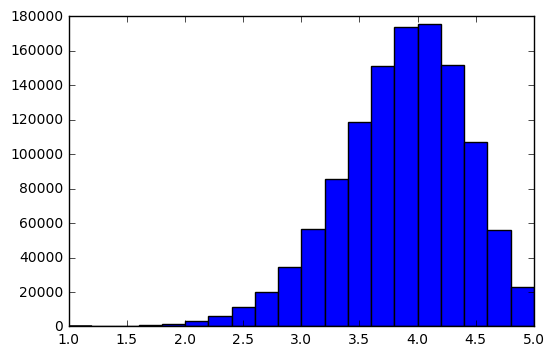

In [20]:
plt.hist(pred, bins=20)

(array([  1.68000000e+02,   1.69000000e+02,   3.90000000e+02,
          7.96000000e+02,   1.64100000e+03,   3.24500000e+03,
          5.97000000e+03,   1.11150000e+04,   2.02600000e+04,
          3.46120000e+04,   5.66110000e+04,   8.53240000e+04,
          1.18744000e+05,   1.51427000e+05,   1.73648000e+05,
          1.75419000e+05,   1.51678000e+05,   1.07001000e+05,
          5.59450000e+04,   2.27890000e+04]),
 array([ 1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,  2.6,  2.8,  3. ,
         3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,  4.6,  4.8,  5. ]),
 <a list of 20 Patch objects>)

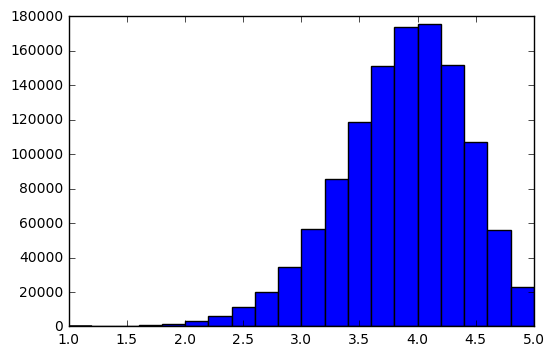

In [21]:
plt.hist(pred, bins=20)